
## Housing prices in Sydney Suburbs:

### 1. Introduction and Problem Statement:

For the purpose of this analysis, 3 datasets (sources mentioned at the end of the document) have been selected. The first dataset represents the historical prices of houses in the Sydney suburban regions. The second dataset represents the locations(latitude and longitude) of these houses and their suburb. The final dataset is the crime statistics for the suburban areas. With these information at our disposal, the following problem statement has been formulated for this portfolio.
***"Given the crime statisitics for a suburb, what is the relationship between the number of crime commited in a subrub and its influence on the average housing prices for the same suburb?"*** . The goal, with this, is to see if crimes influence the housing prices in anyway (increases or decrease the price) and if it does, then observe how significant the correlation is.

For achieving this, a model will be selected based on the analysis of the datasets, the performance of the model will be analyzed and necessary changes will be made according to its performance and finally an observation will be conducted on the findings of the model. All of the outlined steps will be carried out in various sections throughout this notebook. 

In [192]:
#importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [155]:
#importing the datasets
house_locations = pd.read_csv('files/sydney_suburbs.csv')
house_prices = pd.read_csv('files/SydneyHousePrices.csv')
suburb_crimestat = pd.read_csv('files/SuburbData2022.csv')

### 2. Exploring the dataset:

In [156]:
#viewing the house prices
house_prices.head()

,Date,Id,suburb,postalCode,sellPrice,bed,bath,car,propType
0,2019-06-19,1,Avalon Beach,2107,1210000,4.0,2,2.0,house
1,2019-06-13,2,Avalon Beach,2107,2250000,4.0,3,4.0,house
2,2019-06-07,3,Whale Beach,2107,2920000,3.0,3,2.0,house
3,2019-05-28,4,Avalon Beach,2107,1530000,3.0,1,2.0,house
4,2019-05-22,5,Whale Beach,2107,8000000,5.0,4,4.0,house


In [157]:
#viewing the suburb locations
house_locations.head()


,Suburb,Latitude,Longitude
0,Abbotsbury,-33.869285,150.866703
1,Abbotsford,-33.850553,151.129759
2,Acacia Gardens,-33.732459,150.912532
3,Agnes Banks,-33.614508,150.711448
4,Airds,-34.090000,150.826111


In [158]:
#viewing the suburb crime statistics
suburb_crimestat.head()


,Suburb,Offence category,Subcategory,Jan 1995,Feb 1995,Mar 1995,Apr 1995,May 1995,Jun 1995,Jul 1995,...,Mar 2022,Apr 2022,May 2022,Jun 2022,Jul 2022,Aug 2022,Sep 2022,Oct 2022,Nov 2022,Dec 2022
0,Aarons Pass,Homicide,Murder *,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aarons Pass,Homicide,Attempted murder,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aarons Pass,Homicide,"Murder accessory, conspiracy",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aarons Pass,Homicide,Manslaughter *,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aarons Pass,Assault,Domestic violence related assault,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [159]:
#viewing the data shapes

print(f"The shape of the suburb locations dataset is {house_locations.shape}")
print(f"The shape of the housing price dataset is {house_prices.shape}")
print(f"The shape of the suburb crime statistics dataset is {suburb_crimestat.shape}")

The shape of the suburb locations dataset is (680, 3)
The shape of the housing price dataset is (199504, 9)
The shape of the suburb crime statistics dataset is (278380, 339)


#### a. Checking and handling null values:

In [160]:
#checking null values

print(f"Total null values for housing prices : {house_prices.isnull().sum()}")
print(f"Total null values for house suburub locations :{house_locations.isnull().sum()}")
print(f"Total null values for suburb crime statistics : {suburb_crimestat.isnull().sum()}")


Total null values for housing prices : Date              0
Id                0
suburb            0
postalCode        0
sellPrice         0
bed             154
bath              0
car           18151
propType          0
dtype: int64
Total null values for house suburub locations :Suburb       0
Latitude     2
Longitude    2
dtype: int64
Total null values for suburb crime statistics : Suburb              0
Offence category    0
Subcategory         0
Jan 1995            0
Feb 1995            0
                   ..
Aug 2022            0
Sep 2022            0
Oct 2022            0
Nov 2022            0
Dec 2022            0
Length: 339, dtype: int64


From the above result, it can be seen that atleast two datasets have null values. For housing prices, "bed" column has 154 null values whereas "car" column has 18151 null values. These need to be dealt with before we further analyze our data. 

**Car**: For this column, an assumption will be made that "Car" represents a parking spot within the housing area and not driveways. We will also assume that the numbers represent how many vehicles can fit in the spot. So, based on this assumption, we can conclude that the value 0 for the column would mean that the house has no parking spots available. Based on this conclusion, all the null values will then be replaced in this column with "0". 

In [161]:
house_prices['car'].fillna(0, inplace=True)

**Bed**: For this column we are going to assume that "Bed" represents the number of bedrooms in a house. Since a house usually always has a bedroom, it wouldn't be safe to assume that the null numeric values for this column represents "0" bedrooms. Instead, it will better to fill the column with median value of the column as median can be robust against outliers/extreme values. 

In [162]:
house_prices['bed'].fillna(house_prices['bed'].median(), inplace=True)

For the crime statistics dataset, we can make one more check to make sure that none of the many columns present in the dataset have null values

In [163]:
print(np.sum(suburb_crimestat.isna().values))

0


From the result above, we can see that there are no null values for the crime statitstics dataset. 

#### b. Checking and handling outliers:

Since the datasets might contain outliers, it is important to remove them because anomalous values directly affect the model's performance. To check for outliers, suitable statistical plots will be used. Once detected, based on the findings, suitable methodologies will be suggested to handle these anomalous findings. This will be done in the next section "Analysis of the dataset".


### 3. Analysis of the dataset:

**a. Housing Prices Dataset:** Since the aim is to predict the average prices for the houses, the "sellPrice" column will be the top focus for this task as it represents the pricing history of the houses. Since the prices are numerical and we want to see if there are any outliers here, we will first create a boxplot and see if it is feasible for our dataset.


In [164]:
house_prices.describe()

,Id,postalCode,sellPrice,bed,bath,car
count,199504.00000,199504.000000,1.995040e+05,199504.00000,199504.000000,199504.000000
mean,99752.50000,2196.379155,1.269776e+06,3.51608,1.890669,1.760065
std,57591.98839,193.053467,6.948239e+06,1.06624,0.926001,1.154073
min,1.00000,2000.000000,1.000000e+00,1.00000,1.000000,0.000000
25%,49876.75000,2082.000000,7.200000e+05,3.00000,1.000000,1.000000
50%,99752.50000,2144.000000,9.850000e+05,3.00000,2.000000,2.000000
75%,149628.25000,2211.000000,1.475000e+06,4.00000,2.000000,2.000000
max,199504.00000,4878.000000,2.147484e+09,99.00000,99.000000,41.000000


From the above statistical summary, it can be seen that the max value present in the dataset is at 2.14 billion which can be regarded as on outlier since suburban homes fall in the range of millions. This value has increased the range as well as influenced the median of our dataset. We can further analyze if there are other outliers in our dataset using a boxplot or a scatter plot. Since we are dealing with large data with a very large range, we will use a scatter plot to analyze our data. 

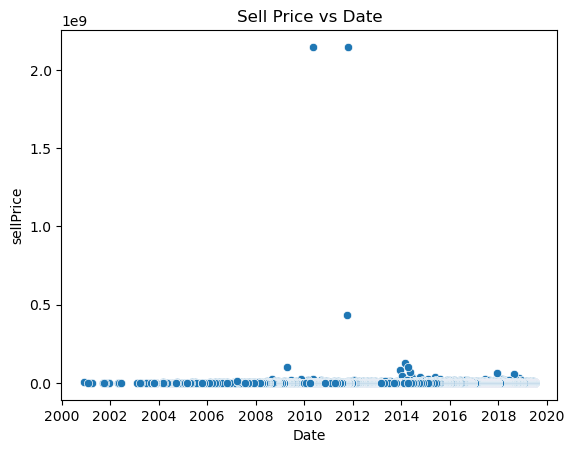

In [165]:
house_prices['Date'] = pd.to_datetime(house_prices['Date'])

sns.scatterplot(data=house_prices, x='Date', y='sellPrice')
plt.title('Sell Price vs Date')
plt.show()

The scatter plot above clearly displays the extreme values, which are in billions. Meanwhile, most of the selling prices are concentrated below the 500 million mark, with a few being clsoe to the 500 million mark. With this information, we can define a boundary for labeling suitable data that aren't further away from the concentrated data points. Looking at the plot, most of the can be classified as extraneous and can be removed safely before training our model. 

For this, we will set our data-cutoff point or the threshold at around 200 million since most of the data points are concentrated around here. This will be done in the data pre-processing portion of the notebook.

**b. Suburban crime statistics dataset**:
The number of crimes committed in a suburb is going to be the predictor of the housing price. The dataset contains crimestatistics from a wide range of timespan, i.e, from January of 1995 to December of 2022.

In [166]:
suburb_crimestat.head()

,Suburb,Offence category,Subcategory,Jan 1995,Feb 1995,Mar 1995,Apr 1995,May 1995,Jun 1995,Jul 1995,...,Mar 2022,Apr 2022,May 2022,Jun 2022,Jul 2022,Aug 2022,Sep 2022,Oct 2022,Nov 2022,Dec 2022
0,Aarons Pass,Homicide,Murder *,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aarons Pass,Homicide,Attempted murder,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aarons Pass,Homicide,"Murder accessory, conspiracy",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aarons Pass,Homicide,Manslaughter *,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aarons Pass,Assault,Domestic violence related assault,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since the focus is on the frequency of crime more than the crime itself, the crimes will be totaled regardless of the category. This gives an overall view of the crime statistics in a suburb. 

In [167]:
total_crimes = suburb_crimestat.groupby('Suburb').sum(numeric_only=True).sum(axis=1).reset_index()
total_crimes.columns = ['Suburb', 'Total Crimes']
total_crimes.head()

,Suburb,Total Crimes
0,Aarons Pass,90
1,Abbotsbury,4019
2,Abbotsford,6436
3,Abercrombie,685
4,Abercrombie River,95


In [168]:
total_crimes.describe()

,Total Crimes
count,4490.000000
mean,4241.006459
std,15132.590628
min,1.000000
25%,47.000000
50%,198.500000
75%,1878.000000
max,384899.000000


### 4. Data preprocessing:

Based on the analysis above, the data needs to be processed before the training phase. After the data has been cleaned, it will then be used to train a suitable model.

**a. Handling outliers from the housing prices dataset**:

For this dataset, the cutoff value was identified to be 200 million in the analysis step. Based on this new threshold, only selling prices below this value will be kept and everything else will be discarded. 

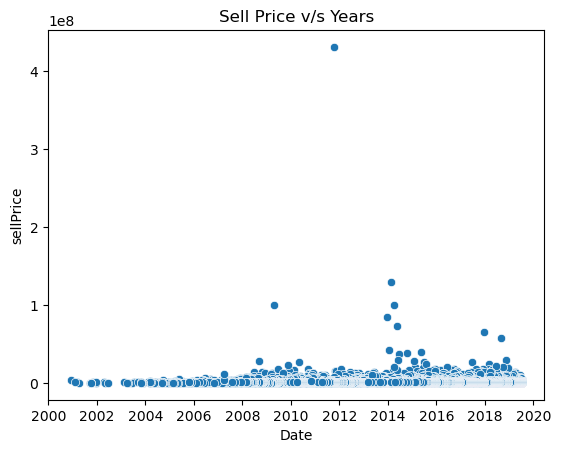

In [169]:
#setting a cut-off value for the selling prices using boolean indexing
limit = 2e9
house_prices = house_prices[house_prices['sellPrice']<limit]
sns.scatterplot(data=house_prices, x='Date', y='sellPrice')
plt.title('Sell Price v/s Years')
plt.show()

With the range of the dataset shortened by removing extreme values, the data can be better visualized from the above scatter plot. Our new range is between around 1 million to 40 million which seems to be a realistic trend of housing prices in sydney suburbs. 
A boxplot can be plotted to further visualize the dataset

<Axes: xlabel='sellPrice'>

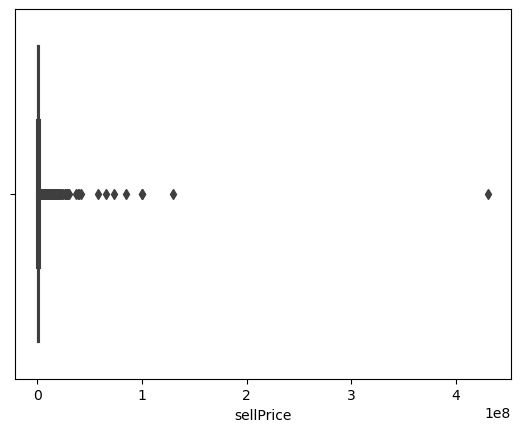

In [170]:
sns.boxplot(x=house_prices['sellPrice'])

The box plot seems to suggest that any prices above around 1.3 millions are outliers. While this seems to be the case, in Sydney, it is fairly reasonable to see the prices go beyond what is normally expected. It isn't uncommon to have houses jump in prices close to 40 million rather than stay at the range of under 5 million. Big mansions also fall under the category of houses, which have high price estimations. Therefore,  we will make the assumption that these values are not outliers and based on this assumption, the values will not be removed.

**b. Averaging the housing prices for the suburbs**:

The goal is to see the relationship between the average housing prices in the suburbs with the crime statistics. So, the selling prices need to be averaged for each suburb based on the year. Since the prices are in millions, standard scaler is used to scale down the magnitude of the values. 

In [227]:
house_price_avg = house_prices.groupby(['suburb', house_prices['Date'].dt.year])['sellPrice'].mean().reset_index()
house_price_avg = house_price_avg.rename(columns={"Date": "Year", "suburb": "Suburb"})

#scaling down the prices
standard_price = StandardScaler()
house_price_avg['sellPrice'] = standard_price.fit_transform(house_price_avg['sellPrice'].values.reshape(-1,1))
house_price_avg.head()

,Suburb,Year,sellPrice
0,Abbotsbury,2011,-0.434368
1,Abbotsbury,2014,-0.185660
2,Abbotsbury,2015,-0.238450
3,Abbotsbury,2016,-0.259361
4,Abbotsbury,2017,-0.170013


**c. Comibining the average prices and total crime statistics data**: 

Since most of the preprocessing of the data before training has been completed, the final version of the data will be combined into a single dataframe which will then be split into training and testing dataset later on. The feature columns, i.e, total crime and year, will also be transformed using standard scaler to remain consistent with the scaling of the selling price label.

In [228]:
standard_feature = StandardScaler()
combined_data = pd.merge(house_price_avg, total_crimes, on = ['Suburb'])
combined_data[['Total Crimes','Year']] = standard_feature.fit_transform(combined_data[['Total Crimes','Year']])

combined_data.head()

,Suburb,Year,sellPrice,Total Crimes
0,Abbotsbury,-0.750091,-0.434368,-0.423812
1,Abbotsbury,0.048689,-0.185660,-0.423812
2,Abbotsbury,0.314949,-0.238450,-0.423812
3,Abbotsbury,0.581209,-0.259361,-0.423812
4,Abbotsbury,0.847469,-0.170013,-0.423812


### 5. Selecting the features,labels and model:

Based on our analysis, sell price and year seems to have a non-linear relationship. Similarly, a scatterplot for selling price and total crimes can be made to see what sort of relationship exists.

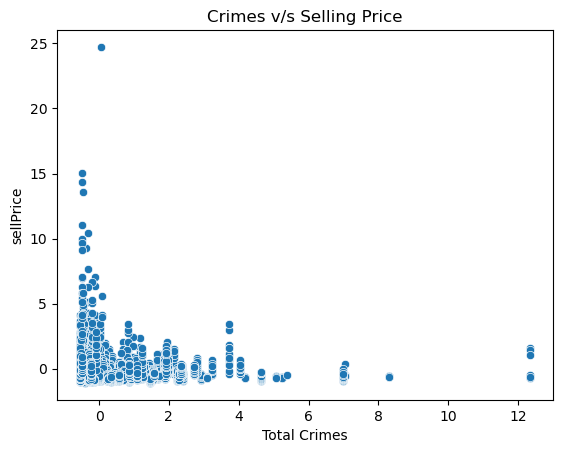

In [217]:
sns.scatterplot(data=combined_data, x='Total Crimes', y='sellPrice')
plt.title('Crimes v/s Selling Price')
plt.show()

The relationship seems to be non-linear for crimes and selling price. The correlation matrix for the dataset is given below

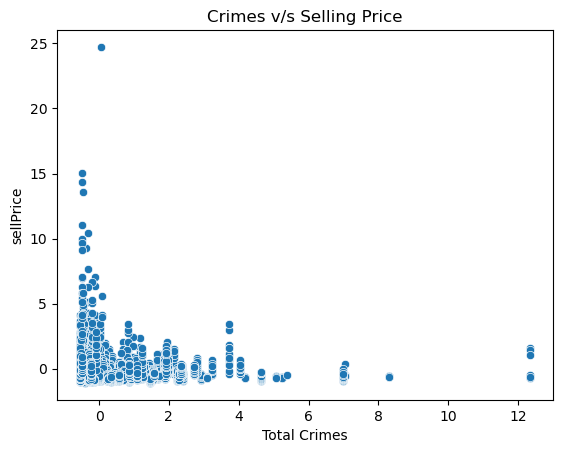

In [229]:
sns.scatterplot(data=combined_data, x='Total Crimes', y='sellPrice')
plt.title('Crimes v/s Selling Price')
plt.show()

In [230]:
combined_data.corr(numeric_only = True)

,Year,sellPrice,Total Crimes
Year,1.000000,0.185044,-0.020254
sellPrice,0.185044,1.000000,-0.069423
Total Crimes,-0.020254,-0.069423,1.000000


The selling price seems to have a positive correlation with year while with total crimes, it seems to have a negative correlation as expected. A real world interpretation/assumption would suggest that prices increase yearly whereas crime rates negatively influence the price estimation of houses in a suburb. 

Now, the features year and the total crimes will be selected while the selling price will be the label.

In [231]:
features = combined_data[['Total Crimes','Year']]
label = combined_data['sellPrice']

Since there is non-linear relationship between selling price/crimes and selling price/year, a multi regression model would be the best choice here. The dataset fails traditional regressional model criteria, i.e, the dataset doesn't exhibit linearity. Thus, multi regression model is used.

### 6. Test/Train splitting of data: 

For the purpose of training the model, 80 % of the data will be used for training and 20 % will be used for testing.


In [232]:
#splitting the data into test/train
feature_train, feature_test, label_train, label_test = train_test_split(features, label, test_size=0.2, random_state=140)

### 7. Training the model:

With the train/test data ready, the multiregressional model can now be trained.


In [233]:
multi_model = LinearRegression()

#fitting the training data

multi_model.fit(feature_train, label_train)


LinearRegression()

In [234]:
#predicting the selling price
price_prediction = multi_model.predict(feature_test)

### 8. Evaluating the model:

To evaluate the model, it's Mean Squared Error(MSE), its root and R2 score will be observed.

In [235]:
mse = mean_squared_error(label_test, price_prediction)
rsq = r2_score(label_test, price_prediction)

print(f"The mean squared error is: {mse}")
print(f"The R2 score is: {rsq}")
print(f"The root mean squared error is : {np.sqrt(mse)}")

The mean squared error is: 0.8228260626224885
The R2 score is: 0.0497878721604873
The root mean squared error is : 0.9070976036912943


#### Analysis of the error metrics:

**MSE**: The MSE score of 0.82 is means that the predicted value and the actual value are not that far off. 

**R2**: The R2 score of 0.049 is a bit lower. This could be due to the lack of complex features/low quantity of features during training. 

**Root MSE**: The Root MSE is 0.9, which, just like MSE, indicates that the predicted values are only off by about 1 units. 

#### Model Summary:

In [236]:
print("The intercept:", multi_model.intercept_)
print("The coefficients:", multi_model.coef_)

The intercept: 0.013139427971540033
The coefficients: [-0.06747665  0.17830173]


#### Residual analysis:

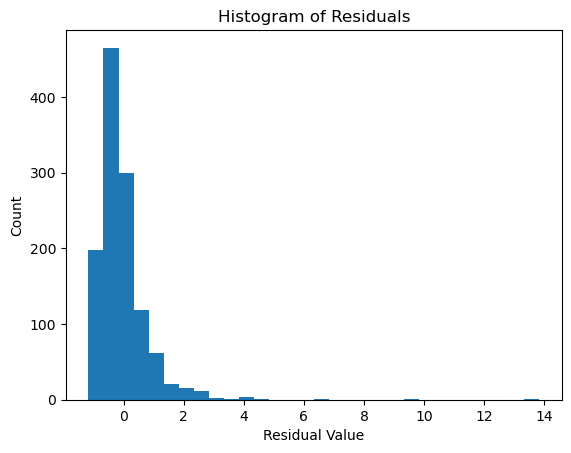

In [241]:
plt.hist(label_test-price_prediction, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Count')
plt.show()

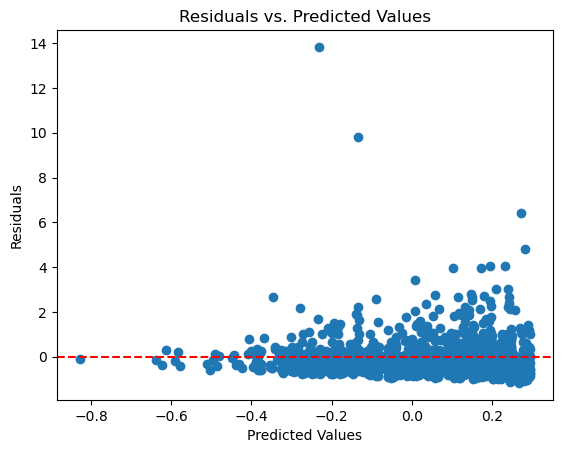

In [247]:
plt.scatter(price_prediction, label_test-price_prediction)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

Looking at the residual charts, it can be seen that the histogram is skewed and the scatter plot is almost non linear. This could mean that while the model had a low error metrics, it still is making big errors. The expected histogram would be a somewhat normal chart

Also, the scatter plot shows that there is some non-linearity in the prediction. This could be because the features are less complex and few in number.

### 7. Summary and conclusion:

Looking at the output of our model, we can say that there is some relationship between the housing prices and the crime statistics. They are negatively correlated meaning housing prices go down when crimes go up. 

However, the model used could have done a better job at making predictions. It still is making big errors when it does so and it isn't encapsulating a linear relationship between the features and labels. In the future, this can be mitigated by using better and complex features, making changes to the data preprocessing steps and by also exploring different models which might be best suited for these dataset. 

### Sources:

Hoang, N. (Year Published). Sydney Housing Price 2000-2019 [Dataset]. Kaggle. Available at: https://www.kaggle.com/code/hoangnhu/sydney-housing-price-2000-2019/input?select=sydney_suburbs.csv [Accessed: 10/15/2023].

Bureau of Crime Statistics and Research. Quarterly Recorded Crime Data Set by Suburb [Dataset]. NSW Government Data. Available at: https://data.nsw.gov.au/data/dataset/crime-data-by-offence [Accessed: 10/15/2023].
